In [1]:
%load_ext rpy2.ipython
%matplotlib inline

import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

## Python API

Prophet follows the `sklearn` model API.  We create an instance of the `Prophet` class and then call its `fit` and `predict` methods.  

The input to Prophet is always a dataframe with two columns: `ds` and `y`.  The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let's look at a time series of the log daily page views for the Wikipedia page for [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning).  We scraped this data using the [Wikipediatrend](https://cran.r-project.org/package=wikipediatrend) package in R.  Peyton Manning provides a nice example because it illustrates some of Prophet's features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning's playoff and superbowl appearances). The CSV is available [here](https://github.com/facebook/prophet/blob/main/examples/example_wp_log_peyton_manning.csv).

First we'll import the data:

In [2]:
import pandas as pd
from neuralprophet import Prophet

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


We fit the model by instantiating a new `Prophet` object.  Any settings to the forecasting procedure are passed into the constructor.  Then you call its `fit` method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [4]:
m = Prophet()
m.fit(df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.31E-02, min: 1.58E-01


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 1.85E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.99E-02
Epoch[142/142]: 100%|██████████| 142/142 [00:09<00:00, 14.63it/s, SmoothL1Loss=0.00559, MAE=0.332, RMSE=0.459, Loss=0.00763, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
0,0.876805,5.848709,7.094567,1.252609,0.0
1,0.777555,5.371451,6.503134,1.047762,0.0
2,0.651228,4.758426,5.773477,0.804689,0.0
3,0.485267,3.928116,4.780122,0.528025,0.0
4,0.290758,2.886356,3.512793,0.279022,0.0
...,...,...,...,...,...
137,0.005624,0.333698,0.463011,0.007705,0.0
138,0.005608,0.331475,0.461429,0.007675,0.0
139,0.005598,0.331420,0.462956,0.007656,0.0
140,0.005591,0.331727,0.462437,0.007640,0.0


Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well. 

In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y
3265,2017-01-15,None
3266,2017-01-16,None
3267,2017-01-17,None
3268,2017-01-18,None
3269,2017-01-19,None


The `predict` method will assign each row in `future` a predicted value which it names `yhat`.  If you pass in historical dates, it will provide an in-sample fit. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [6]:
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,residual1,yhat1,yhat1 19.999999999999996%,yhat1 80.0%,trend,season_yearly,season_weekly
0,2007-12-10,9.590761,-0.960158,8.630603,8.316385,8.976242,7.912044,0.353625,0.364934
1,2007-12-11,8.51959,-0.136494,8.383097,8.195433,8.593624,7.912823,0.348008,0.122266
2,2007-12-12,8.183677,0.001717,8.185393,8.011393,8.345317,7.913602,0.343751,-0.071960
3,2007-12-13,8.072467,0.113878,8.186345,8.010657,8.366634,7.914381,0.340989,-0.069025
4,2007-12-14,7.893572,0.294704,8.188276,7.991344,8.379772,7.915160,0.339845,-0.066728
...,...,...,...,...,...,...,...,...,...
3265,2017-01-15,None,NaN,8.240804,7.909243,8.626868,7.176910,1.019592,0.044301
3266,2017-01-16,None,NaN,8.572687,8.173113,9.072556,7.175881,1.031872,0.364934
3267,2017-01-17,None,NaN,8.338434,8.059299,8.712496,7.174852,1.041317,0.122266
3268,2017-01-18,None,NaN,8.149656,7.878711,8.481493,7.173822,1.047793,-0.071960


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

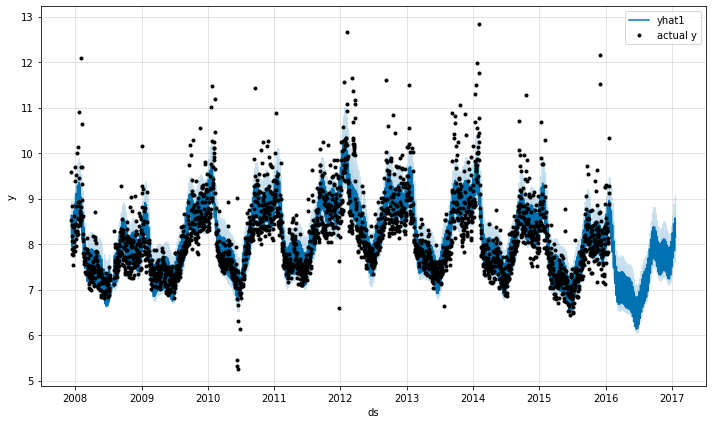

In [7]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the `Prophet.plot_components` method.  By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series.  If you include holidays, you'll see those here, too.

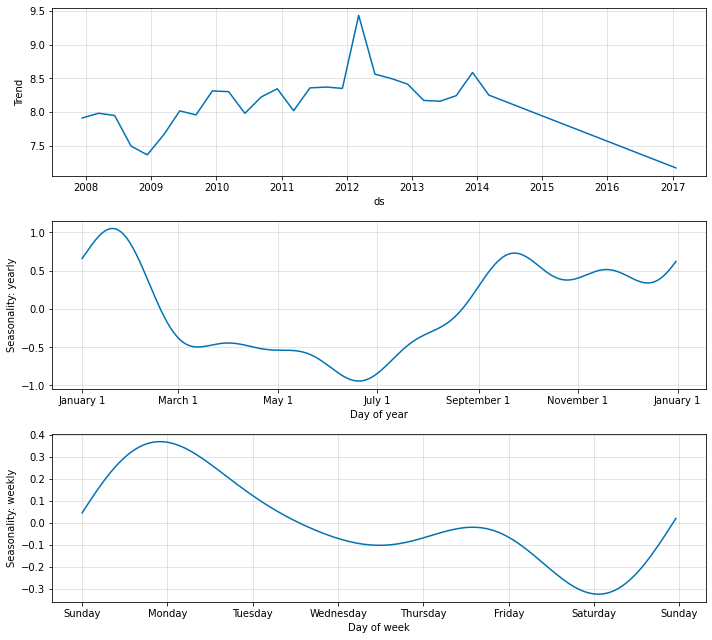

In [8]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the `notebook` and `ipywidgets` packages.

In [10]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [11]:
plot_components_plotly(m, forecast)